In [43]:
%load_ext autoreload
%autoreload 2

from data_prep import DataPreparation, filtering_data
from lstm import LSTMModelTrainerAttention, LSTMRollingForecaster
from rf import RandomForestTrainer
from lgbm import LightGBMTrainer
from catboost_trainer import CatBoostTrainer
import os
import dill as pickle
import numpy as np
import pandas as pd
from tqdm import tqdm


import warnings
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
output= r'C:\Users\iLabs_6\Documents\Tex\allwithCBAS'
modelname = 'extended_df_ATOT'

 
with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_df = pickle.load(f)

extended_df['cap_DEP'].fillna(extended_df['cap_DEP'].mean(), inplace=True)
extended_df['cap_DES'].fillna(extended_df['cap_DES'].mean(), inplace=True)
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_eobt', case=False)]
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_atot', case=False)]
pd.set_option("display.max_columns", None)
X, y, colnames = filtering_data(extended_df, airport ='EHAM', save=True)
X = X.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
X.describe()

output= r'C:\Users\iLabs_6\Documents\Tex\allwithCBAS'
modelname = 'extended_df_ETOT'


with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_real= pickle.load(f)
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_eobt', case=False)]
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_atot', case=False)]

pd.set_option("display.max_columns", None)
print(f'{extended_real}')
X_r, y_r, colnames = filtering_data(extended_real, airport ='EHAM', save=False)
X_r = X_r.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
# X.fillna(0, inplace=True)
print(f'xxxxx = {X_r}')

C:\Users\iLabs_6\AppData\Local\Temp\ipykernel_511136\1309876589.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  extended_df['cap_DEP'].fillna(extended_df['cap_DEP'].mean(), inplace=True)
C:\Users\iLabs_6\AppData\Local\Temp\ipykernel_511136\1309876589.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

           distance                ETOT  ADEP  ADES                EOBT  \
0      14437.477905 2024-01-23 06:10:00  LSZH  EHAM 2024-01-23 05:55:00   
1       4949.190326 2024-01-23 16:05:00  EPWA  EHAM 2024-01-23 15:50:00   
2      10210.682956 2024-01-27 08:30:00  ENGM  EHAM 2024-01-27 08:20:00   
3      17013.465682 2024-01-29 05:11:00  EDDS  EHAM 2024-01-29 05:00:00   
4       4949.190326 2024-01-31 16:05:00  EPWA  EHAM 2024-01-31 15:50:00   
...             ...                 ...   ...   ...                 ...   
70709   9085.158293 2024-01-22 15:45:00  EDDF  EHAM 2024-01-22 15:30:00   
70710  12922.196222 2024-01-22 14:30:00  EFHK  EHAM 2024-01-22 14:20:00   
70711   9977.022009 2024-01-22 16:40:00  EIDW  EHAM 2024-01-22 16:20:00   
70712  14982.537341 2024-01-22 14:35:00  EKCH  EHAM 2024-01-22 14:25:00   
70713   4949.190326 2024-01-22 19:30:00  EPWA  EHAM 2024-01-22 19:15:00   

                      ETA    CDMStatus  taxitime event  regulations  \
0     2024-01-23 07:29:00  D

In [41]:
data_prep = DataPreparation()


X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, time_horizons, cbaslabels = data_prep.fit_transform_data(X, y)
X_real, ETOT_horizons, cbaslabels = data_prep.transform_data(X_r)

X_train, X_test, y_train, y_test = data_prep.fit_transform_data(X, y, split_ratio=0.8, mode='rf')


time_varying_columns=['atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 'atfmdelay_Tmin_-290', 'regulations_Tmin_-290', 'cobt_delay_Tmin_-290', 'eflighttime_Tmin_-290', 'visibility_Tmin_-290', 'ko_Tmin_-290', 'TSATdelay_Tmin_-290'

time_varying_columns=['atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 'atfmdelay_Tmin_-290', 'regulations_Tmin_-290', 'cobt_delay_Tmin_-290', 'eflighttime_Tmin_-290', 'visibility_Tmin_-290', 'ko_Tmin_-290', 'TSATdelay_Tmin_-290'

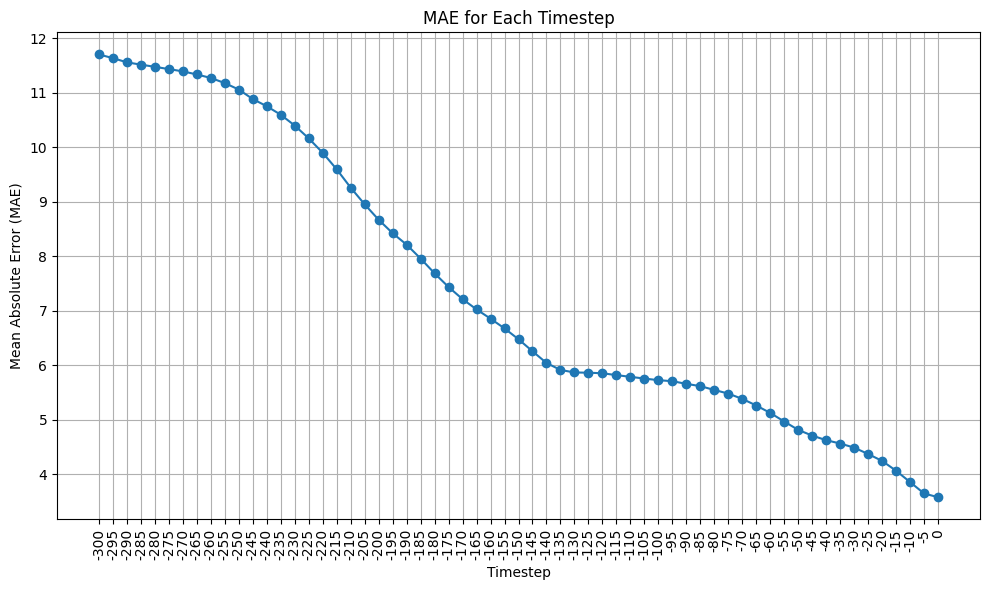

In [28]:
model_trainer = LSTMModelTrainerAttention(data_prep=data_prep, input_size=data_prep.input_size, model_type='varattention')

# Set data loaders
model_trainer.set_data_loaders(data_prep.train_loader, data_prep.test_loader, data_prep.time_steps)

# ANDERE SWITCH, afhankelijk van eerste prediction
best_model = model_trainer.hyperparameter_search(1)
#2707 16 it
# Evaluate the best model and plot the results
y_pred, y_test = model_trainer.evaluate_and_plot(best_model, X_test_tensor, y_test_tensor, data_prep.scaler_y, time_horizons)

#2536

In [30]:
output= r"C:\Users\iLabs_6\Documents\Tex\AirTrafficDelays\LSTM_Models"

modelname = 'lstm-9-100-2526'
with open(os.path.join(output, modelname), 'wb') as f:  
    pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"FlightDataset has been saved successfully. {modelname}")

with  open(os.path.join(output, modelname), 'rb') as f:  
    best_model = pickle.load(f)


FlightDataset has been saved successfully. lstm-9-100-2526


Non-zero indices in y_r: [   18    40    48 ... 70470 70500 70521]


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


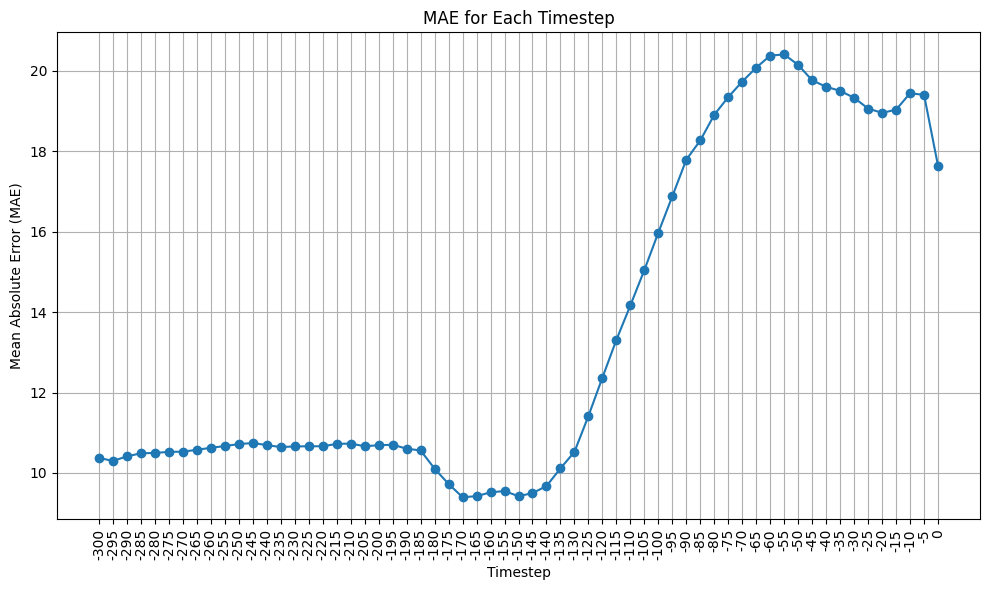

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

ap = []
target_length = 61  # Target length for each error array
start_idx, end_idx = 16000, 17000  # Define your index range as variables
start_idx, end_idx = -1502, -1500  # Define your index range as variables5

# Debug: Print initial data for checking
print(f'Non-zero indices in y_r: {np.where(y_r == 1)[0]}')

# Loop through the specified range in `y_r`
for fnr in tqdm(np.where( (y_r <= 120))[0][start_idx:end_idx]): # (y_r>=0) &
    # Create rolling forecaster instance
    recursive = LSTMRollingForecaster(best_model, data_prep, X_real[fnr], ETOT_horizons)
    pred = recursive.rolling_forecast()
    # Calculate absolute error per timestep
    absolute_error_per_timestep = np.abs(pred[-target_length:] - y_r[fnr])

    # Ensure each error array has `target_length` elements by padding with NaNs if needed
    if len(absolute_error_per_timestep) < target_length:
        padded_error = np.pad(absolute_error_per_timestep, (0, target_length - len(absolute_error_per_timestep)), constant_values=np.nan)
        ap.append(padded_error)
    else:
        ap.append(absolute_error_per_timestep)

        # Plot the MAE for each timestep

mae_per_timestep = np.nanmean(ap, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(ETOT_horizons[:target_length], mae_per_timestep, marker='o')
plt.xlabel('Timestep')
plt.xticks(ETOT_horizons[:target_length], rotation='vertical')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE for Each Timestep')
plt.tight_layout()
plt.grid(True)

plt.show()

In [39]:
# Initialize RandomForestTrainer with desired hyperparameters
trainer_rf = RandomForestTrainer(dataprep=data_prep,n_estimators=20, max_depth=10, min_samples_split=5, horizons=data_prep.time_horizons)

# # Share the scaler_y between data_prep_rf and trainer_rf
trainer_rf.scaler_y = data_prep.scaler_y

# # Train the model
# trainer_rf.train(X_train, y_train)

time_varying_columns=['atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 'atfmdelay_Tmin_-290', 'regulations_Tmin_-290', 'cobt_delay_Tmin_-290', 'eflighttime_Tmin_-290', 'visibility_Tmin_-290', 'ko_Tmin_-290', 'TSATdelay_Tmin_-290'

In [40]:
trainer_rf.evaluate(X_test, y_test)

KeyboardInterrupt: 

In [33]:
trainer_gbm = LightGBMTrainer(dataprep=data_prep,n_estimators=20, max_depth=10, min_samples_split=5, horizons=data_prep.time_horizons)

# Share the scaler_y between data_prep_rf and trainer_rf
trainer_gbm.scaler_y = data_prep.scaler_y

# Train the model
# trainer_gbm.train(X_train, y_train)

Created model directory at: lgbm_models


Loaded model for Timestep -300 from lgbm_models\lgbm_-300.pkl
Loaded model for Timestep -295 from lgbm_models\lgbm_-295.pkl
Loaded model for Timestep -290 from lgbm_models\lgbm_-290.pkl
Loaded model for Timestep -285 from lgbm_models\lgbm_-285.pkl
Loaded model for Timestep -280 from lgbm_models\lgbm_-280.pkl
Loaded model for Timestep -275 from lgbm_models\lgbm_-275.pkl
Loaded model for Timestep -270 from lgbm_models\lgbm_-270.pkl
Loaded model for Timestep -265 from lgbm_models\lgbm_-265.pkl
Loaded model for Timestep -260 from lgbm_models\lgbm_-260.pkl
Loaded model for Timestep -255 from lgbm_models\lgbm_-255.pkl
Loaded model for Timestep -250 from lgbm_models\lgbm_-250.pkl
Loaded model for Timestep -245 from lgbm_models\lgbm_-245.pkl
Loaded model for Timestep -240 from lgbm_models\lgbm_-240.pkl
Loaded model for Timestep -235 from lgbm_models\lgbm_-235.pkl
Loaded model for Timestep -230 from lgbm_models\lgbm_-230.pkl
Loaded model for Timestep -225 from lgbm_models\lgbm_-225.pkl
Loaded m

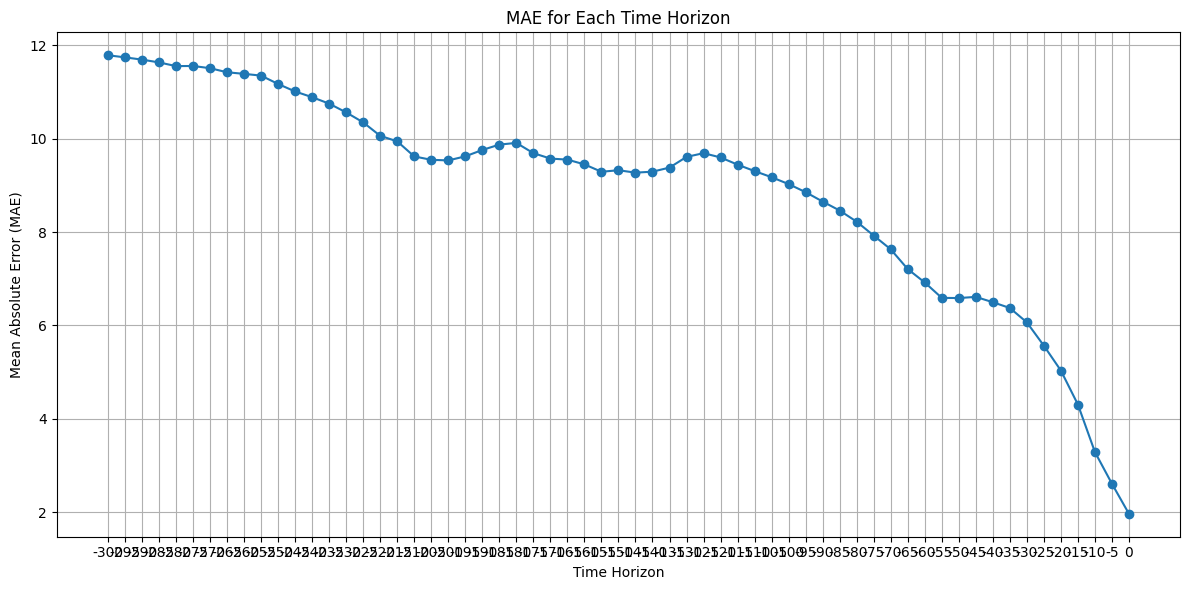

[11.786294044536493,
 11.741367128369399,
 11.692795688201802,
 11.633181594483837,
 11.554130472238603,
 11.556592261553641,
 11.509164299797954,
 11.421962383498519,
 11.38790789501304,
 11.350131239255559,
 11.170863591649196,
 11.010239393714656,
 10.888141374998817,
 10.74966142760099,
 10.562031667964582,
 10.34846013166069,
 10.059977073452217,
 9.941965589724486,
 9.619021369848998,
 9.54667434854921,
 9.53372795301618,
 9.62102812777668,
 9.757362948315357,
 9.87242831097382,
 9.908831440057336,
 9.688936572510881,
 9.57330247890661,
 9.550560726297492,
 9.449152841087685,
 9.290567807415098,
 9.323402291342264,
 9.27175928390523,
 9.292337483782248,
 9.380136648272059,
 9.608932025144773,
 9.688887652531138,
 9.597413216756163,
 9.443200399103977,
 9.305190720547069,
 9.173883909356082,
 9.026554342992196,
 8.85345633319202,
 8.65248550386362,
 8.460195173887218,
 8.221084790418127,
 7.923982378185983,
 7.629400391055539,
 7.2059979832593735,
 6.919146764254058,
 6.5892934917

In [35]:
trainer_gbm.evaluate(X_test, y_test)

In [37]:
trainer_cat = CatBoostTrainer(dataprep=data_prep, horizons=data_prep.time_horizons)

# Share the scaler_y between data_prep_rf and trainer_rf
trainer_cat.scaler_y = data_prep.scaler_y

# Train the model
# trainer_cat.train(X_train, y_train)

Model directory already exists at: catboost_models


Loaded model for Timestep -300 from catboost_models\catboost_-300.pkl
Loaded model for Timestep -295 from catboost_models\catboost_-295.pkl
Loaded model for Timestep -290 from catboost_models\catboost_-290.pkl
Loaded model for Timestep -285 from catboost_models\catboost_-285.pkl
Loaded model for Timestep -280 from catboost_models\catboost_-280.pkl
Loaded model for Timestep -275 from catboost_models\catboost_-275.pkl
Loaded model for Timestep -270 from catboost_models\catboost_-270.pkl
Loaded model for Timestep -265 from catboost_models\catboost_-265.pkl
Loaded model for Timestep -260 from catboost_models\catboost_-260.pkl
Loaded model for Timestep -255 from catboost_models\catboost_-255.pkl
Loaded model for Timestep -250 from catboost_models\catboost_-250.pkl
Loaded model for Timestep -245 from catboost_models\catboost_-245.pkl
Loaded model for Timestep -240 from catboost_models\catboost_-240.pkl
Loaded model for Timestep -235 from catboost_models\catboost_-235.pkl
Loaded model for Tim

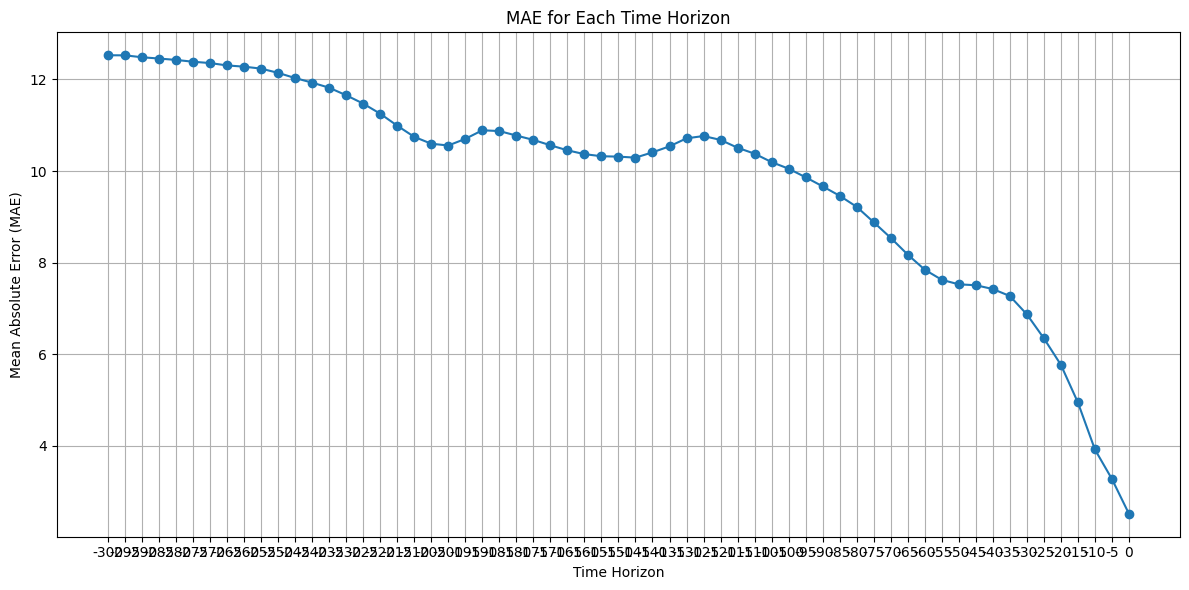

[12.528761491717882,
 12.52704123253812,
 12.485254169013496,
 12.457222695756794,
 12.426888719149186,
 12.387403312837861,
 12.358205376670208,
 12.306657214836433,
 12.279813001485621,
 12.236684270354337,
 12.144186769618456,
 12.030633646244448,
 11.930892912036251,
 11.819782157078256,
 11.654865288786334,
 11.472780534385535,
 11.251733417093702,
 10.990335360970256,
 10.7459628752551,
 10.596474926143916,
 10.55750920095829,
 10.702831902008642,
 10.889916524197774,
 10.873347907106345,
 10.774636839424167,
 10.680114697358066,
 10.562516603754753,
 10.452334124205883,
 10.369087394907812,
 10.323228165236994,
 10.314376297267376,
 10.29251184018139,
 10.407865620044547,
 10.539619502020265,
 10.714188221695188,
 10.764599610159776,
 10.679658479789628,
 10.508692982130928,
 10.378927981843741,
 10.194930918934661,
 10.051083145686016,
 9.863460529263666,
 9.665388489697166,
 9.459341754086212,
 9.218166125046004,
 8.88218633218284,
 8.540313938436602,
 8.17442877184843,
 7.844

In [38]:
trainer_cat.evaluate(X_test, y_test)